# Regression: Predicting fuel efficiency

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-09-24 02:18:52.037577: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 02:18:52.037678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 02:18:52.042045: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-24 02:18:52.067787: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# List all physical devices recognized by TensorFlow
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)
if gpus :
    try:
        for gpu in gpus:
            print("1")
            tf.config.experimental.set_memory_growth(gpu, True)
            print("2")
        print("3")
        tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 10)])
        print("4")
    except RuntimeError as e:
        print("5")
        print(e)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1
2
3
4


2024-09-24 02:18:58.695327: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-24 02:18:58.726211: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-24 02:18:58.731278: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).



### Get the data
First download the dataset.

In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

Import it using pandas

In [6]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1

### Clean the data

The dataset contains a few unknown values.

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

One simple option is to drop those rows.

In [8]:
dataset = dataset.dropna()

The `"Origin"` column is really categorical, not numeric. So convert that to a one-hot:

In [9]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [10]:
# dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))

dataset['USA'] = dataset['Origin'].apply(lambda x: 1 if x == 1 else 0)
dataset['Europe'] = dataset['Origin'].apply(lambda x: 1 if x == 2 else 0)
dataset['Japan'] = dataset['Origin'].apply(lambda x: 1 if x == 3 else 0)
dataset = dataset.drop('Origin', axis=1)

In [11]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  USA  Europe  Japan  
393          82    1       0      0  
394          82    0       1      0  
395          82    1       0      0  
396          82    1       0      0  
397          82    1       0      0

In [12]:
unique_model_years = dataset['Model Year'].nunique()
unique_cylinders = dataset['Cylinders'].nunique()

print(f"Unique Model Years: {unique_model_years}")
print(f"Unique Cylinders: {unique_cylinders}")

Unique Model Years: 13
Unique Cylinders: 5


### Split the data into train and test

Now split the dataset into a training set and a test set.

In [13]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

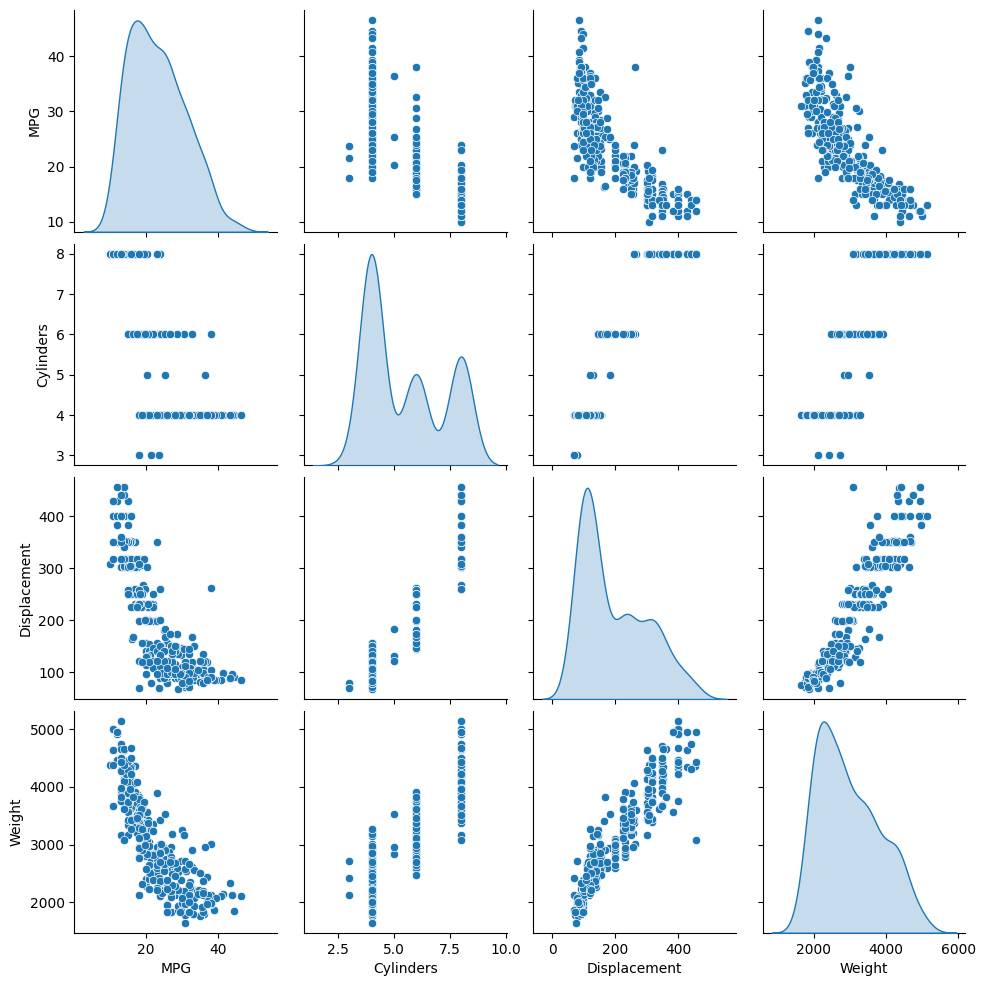

In [14]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Also look at the overall statistics:

In [15]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

count         mean         std     min      25%     50%  \
Cylinders     314.0     5.477707    1.699788     3.0     4.00     4.0   
Displacement  314.0   195.318471  104.331589    68.0   105.50   151.0   
Horsepower    314.0   104.869427   38.096214    46.0    76.25    94.5   
Weight        314.0  2990.251592  843.898596  1649.0  2256.50  2822.5   
Acceleration  314.0    15.559236    2.789230     8.0    13.80    15.5   
Model Year    314.0    75.898089    3.675642    70.0    73.00    76.0   
USA           314.0     0.624204    0.485101     0.0     0.00     1.0   
Europe        314.0     0.178344    0.383413     0.0     0.00     0.0   
Japan         314.0     0.197452    0.398712     0.0     0.00     0.0   

                  75%     max  
Cylinders        8.00     8.0  
Displacement   265.75   455.0  
Horsepower     128.00   225.0  
Weight        3608.00  5140.0  
Acceleration    17.20    24.8  
Model Year      79.00    82.0  
USA              1.00     1.0  
Europe           0.00     1.0  
Japan            0.00     1.0

In [16]:
train_dataset

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
146  28.0          4          90.0        75.0  2125.0          14.5   
282  22.3          4         140.0        88.0  2890.0          17.3   
69   12.0          8         350.0       160.0  4456.0          13.5   
378  38.0          4         105.0        63.0  2125.0          14.7   
331  33.8          4          97.0        67.0  2145.0          18.0   
..    ...        ...           ...         ...     ...           ...   
281  19.8          6         200.0        85.0  2990.0          18.2   
229  16.0          8         400.0       180.0  4220.0          11.1   
150  26.0          4         108.0        93.0  2391.0          15.5   
145  32.0          4          83.0        61.0  2003.0          19.0   
182  28.0          4         107.0        86.0  2464.0          15.5   

     Model Year  USA  Europe  Japan  
146          74    1       0      0  
282          79    1       0      0  
69           72    1       0      0  
378          82    1       0      0  
331          80    0       0      1  
..          ...  ...     ...    ...  
281          79    1       0      0  
229          77    1       0      0  
150          74    0       0      1  
145          74    0       0      1  
182          76    0       1      0  

[314 rows x 10 columns]

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [17]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [18]:
# Inspection
train_stats

count         mean         std     min      25%     50%  \
Cylinders     314.0     5.477707    1.699788     3.0     4.00     4.0   
Displacement  314.0   195.318471  104.331589    68.0   105.50   151.0   
Horsepower    314.0   104.869427   38.096214    46.0    76.25    94.5   
Weight        314.0  2990.251592  843.898596  1649.0  2256.50  2822.5   
Acceleration  314.0    15.559236    2.789230     8.0    13.80    15.5   
Model Year    314.0    75.898089    3.675642    70.0    73.00    76.0   
USA           314.0     0.624204    0.485101     0.0     0.00     1.0   
Europe        314.0     0.178344    0.383413     0.0     0.00     0.0   
Japan         314.0     0.197452    0.398712     0.0     0.00     0.0   

                  75%     max  
Cylinders        8.00     8.0  
Displacement   265.75   455.0  
Horsepower     128.00   225.0  
Weight        3608.00  5140.0  
Acceleration    17.20    24.8  
Model Year      79.00    82.0  
USA              1.00     1.0  
Europe           0.00     1.0  
Japan            0.00     1.0

In [19]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_test_data.tail()

Cylinders  Displacement  Horsepower    Weight  Acceleration  Model Year  \
369  -0.869348     -0.798593   -0.442811 -0.705359      0.875068    1.660094   
375  -0.869348     -0.865687   -0.810302 -1.197124     -0.092942    1.660094   
382  -0.869348     -0.836932   -0.915299 -0.883106      0.480693    1.660094   
384  -0.869348     -0.999874   -0.994047 -1.214899      0.050467    1.660094   
396  -0.869348     -0.721914   -0.679055 -0.432815      1.090181    1.660094   

          USA    Europe     Japan  
369  0.774676 -0.465148 -0.495225  
375 -1.286751  2.143005 -0.495225  
382 -1.286751 -0.465148  2.012852  
384 -1.286751 -0.465148  2.012852  
396  0.774676 -0.465148 -0.495225

In [20]:
# type(normed_train_data)

In [21]:
# def new_norm(x):
#     return ((x.loc[:, train_stats.index] - train_stats['mean']) / train_stats['std']).join(x.loc[:, ["Europe", "Japan", "USA"]]) 
# new_normed_train_data = norm(train_dataset)
# new_normed_test_data = norm(test_dataset)

In [22]:
# def pass_through(x):
#     return (x.loc[:, ["Europe", "Japan", "USA"]])

# pass_train_data = pass_through(train_dataset)
# pass_train_data

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

In [23]:
train_dataset


Cylinders  Displacement  Horsepower  Weight  Acceleration  Model Year  \
146          4          90.0        75.0  2125.0          14.5          74   
282          4         140.0        88.0  2890.0          17.3          79   
69           8         350.0       160.0  4456.0          13.5          72   
378          4         105.0        63.0  2125.0          14.7          82   
331          4          97.0        67.0  2145.0          18.0          80   
..         ...           ...         ...     ...           ...         ...   
281          6         200.0        85.0  2990.0          18.2          79   
229          8         400.0       180.0  4220.0          11.1          77   
150          4         108.0        93.0  2391.0          15.5          74   
145          4          83.0        61.0  2003.0          19.0          74   
182          4         107.0        86.0  2464.0          15.5          76   

     USA  Europe  Japan  
146    1       0      0  
282    1       0      0  
69     1       0      0  
378    1       0      0  
331    0       0      1  
..   ...     ...    ...  
281    1       0      0  
229    1       0      0  
150    0       0      1  
145    0       0      1  
182    0       1      0  

[314 rows x 9 columns]

In [24]:
normed_train_data.tail()

Cylinders  Displacement  Horsepower    Weight  Acceleration  Model Year  \
281   0.307270      0.044872   -0.521559 -0.000298      0.946772    0.843910   
229   1.483887      1.961837    1.972127  1.457223     -1.598734    0.299787   
150  -0.869348     -0.836932   -0.311564 -0.710099     -0.021237   -0.516397   
145  -0.869348     -1.076553   -1.151543 -1.169870      1.233589   -0.516397   
182  -0.869348     -0.846517   -0.495310 -0.623596     -0.021237    0.027726   

          USA    Europe     Japan  
281  0.774676 -0.465148 -0.495225  
229  0.774676 -0.465148 -0.495225  
150 -1.286751 -0.465148  2.012852  
145 -1.286751 -0.465148  2.012852  
182 -1.286751  2.143005 -0.495225

In [25]:
len(train_dataset.keys())

9

## The model

In [26]:
#INSERT YOUR CODE TO BUILD AND COMPILE THE MODEL HERE
#YOU CAN ALSO CHANGE THE MODEL TRAINING PARAMETERS BELOW

# Fake model slapped together by GPT
def build_model():
  model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()


2024-09-24 02:19:12.793681: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-24 02:19:12.798762: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-24 02:19:12.803751: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [27]:
# Custom callback to evaluate on test data every x epochs
class TestCallback(tf.keras.callbacks.Callback):
    def __init__(self, normed_test_data, test_labels, every_x_epochs=200):
        self.normed_test_data = normed_test_data
        self.test_labels = test_labels
        self.every_x_epochs = every_x_epochs

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.every_x_epochs == 0:
            # loss, mae, mse = self.model.evaluate(self.test_data, self.test_labels, verbose=0)
            # print(f"\nTesting loss: {loss}, mae: {mae}, mse: {mse} at epoch {epoch + 1}\n")

            loss, mae, mse = self.model.evaluate(self.normed_test_data, self.test_labels, verbose=2)
            print("Testing set Mean Abs Error: {:5.2f} MPG\n".format(mae))
            
test_callback = TestCallback(normed_test_data, test_labels, every_x_epochs=50)

In [28]:
EPOCHS = 1000
BATCH_SIZE = 1024

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots(), test_callback],
  batch_size=BATCH_SIZE
)

loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

2024-09-24 02:19:23.584716: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1cf19677a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-24 02:19:23.584795: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-09-24 02:19:23.605117: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-24 02:19:23.655476: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1727144363.813267  211443 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch: 0, loss:601.7661,  mae:23.1814,  mse:601.7661,  val_loss:616.8282,  val_mae:23.7522,  val_mse:616.8282,  
.3/3 - 0s - loss: 631.4895 - mae: 23.9696 - mse: 631.4895 - 109ms/epoch - 36ms/step
Testing set Mean Abs Error: 23.97 MPG

..................................................3/3 - 0s - loss: 582.7350 - mae: 23.2021 - mse: 582.7350 - 91ms/epoch - 30ms/step
Testing set Mean Abs Error: 23.20 MPG

.................................................
Epoch: 100, loss:427.0706,  mae:20.4469,  mse:427.0706,  val_loss:526.0285,  val_mae:22.1514,  val_mse:526.0285,  
.3/3 - 0s - loss: 534.3799 - mae: 22.3019 - mse: 534.3799 - 92ms/epoch - 31ms/step
Testing set Mean Abs Error: 22.30 MPG

..................................................3/3 - 0s - loss: 446.5320 - mae: 20.4233 - mse: 446.5320 - 93ms/epoch - 31ms/step
Testing set Mean Abs Error: 20.42 MPG

.................................................
Epoch: 200, loss:233.6537,  mae:14.9349,  mse:233.6537,  val_loss:327.9820,  val_mae

Visualize the model's training progress using the stats stored in the `history` object.

In [29]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(50)

loss       mae       mse  val_loss   val_mae   val_mse  epoch
950  7.502951  2.033015  7.502951  7.380184  2.188943  7.380184    950
951  6.177792  1.840657  6.177792  7.135806  2.144891  7.135806    951
952  8.044436  2.120300  8.044436  8.324622  2.305431  8.324622    952
953  7.616901  2.213851  7.616901  7.120353  2.118651  7.120353    953
954  6.264843  1.938979  6.264843  6.858293  2.098144  6.858293    954
955  6.835955  1.955684  6.835955  8.324856  2.235250  8.324856    955
956  7.374295  1.988665  7.374295  6.615827  2.089514  6.615827    956
957  7.976673  2.155998  7.976673  7.399934  2.162427  7.399934    957
958  6.907888  2.015855  6.907888  7.349599  2.203490  7.349599    958
959  6.834369  2.085259  6.834369  7.791935  2.206365  7.791935    959
960  6.946272  2.046076  6.946272  7.653906  2.223417  7.653906    960
961  6.329952  1.872310  6.329952  8.323124  2.286414  8.323124    961
962  6.956728  2.052022  6.956728  7.734578  2.126597  7.734578    962
963  6.173298  1.898692  6.173298  8.493743  2.281770  8.493743    963
964  7.348059  1.998931  7.348059  7.222657  2.108760  7.222657    964
965  6.035747  1.855174  6.035747  7.252196  2.117208  7.252196    965
966  7.979932  2.165468  7.979932  7.708601  2.156164  7.708601    966
967  6.839997  1.983619  6.839997  7.996426  2.222070  7.996426    967
968  6.982120  2.054858  6.982120  8.578501  2.306849  8.578501    968
969  7.114549  2.035425  7.114549  7.765054  2.233777  7.765054    969
970  7.505322  2.064181  7.505322  8.685396  2.316780  8.685396    970
971  6.197629  1.860239  6.197629  7.218240  2.161772  7.218240    971
972  5.661787  1.832071  5.661787  7.023055  2.106096  7.023055    972
973  6.940612  1.894058  6.940612  7.868918  2.187690  7.868918    973
974  6.473362  1.985676  6.473362  7.267443  2.210673  7.267443    974
975  6.143166  1.944355  6.143166  7.956703  2.235004  7.956703    975
976  6.912852  1.944587  6.912852  7.518467  2.136705  7.518467    976
977  6.442492  1.940030  6.442492  7.433071  2.115674  7.433071    977
978  7.927094  2.059603  7.927094  7.211770  2.101109  7.211770    978
979  6.150197  1.848009  6.150197  7.477734  2.135142  7.477734    979
980  6.401680  1.951118  6.401680  7.566448  2.198600  7.566448    980
981  7.128853  2.053758  7.128853  7.009654  2.163869  7.009654    981
982  7.175740  1.967348  7.175740  7.145816  2.178075  7.145816    982
983  5.597978  1.756338  5.597978  8.222640  2.267186  8.222640    983
984  7.074065  2.057286  7.074065  8.253367  2.262809  8.253367    984
985  5.733792  1.846296  5.733792  7.855888  2.211959  7.855888    985
986  6.434772  1.992249  6.434772  7.171095  2.118233  7.171095    986
987  6.897335  1.948500  6.897335  8.641081  2.196836  8.641081    987
988  6.964820  1.980725  6.964820  6.978973  2.007736  6.978973    988
989  6.876313  2.035254  6.876313  6.809157  2.007878  6.809157    989
990  5.889102  1.879405  5.889102  7.107379  2.049622  7.107379    990
991  6.796429  1.987153  6.796429  6.735910  2.003724  6.735910    991
992  7.529678  2.023726  7.529678  6.648544  2.070155  6.648544    992
993  5.176423  1.754584  5.176423  7.197737  2.099638  7.197737    993
994  7.764249  2.165016  7.764249  6.764218  2.050047  6.764218    994
995  7.883083  2.123554  7.883083  8.489587  2.281083  8.489587    995
996  5.988998  1.821384  5.988998  6.394331  1.989199  6.394331    996
997  5.092627  1.691442  5.092627  7.004174  2.041604  7.004174    997
998  6.490612  1.911517  6.490612  6.671468  2.014081  6.671468    998
999  7.607724  2.066895  7.607724  6.697750  2.012637  6.697750    999

In [30]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

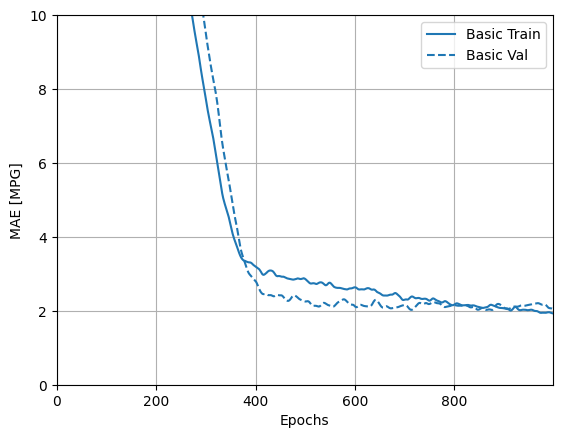

In [31]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

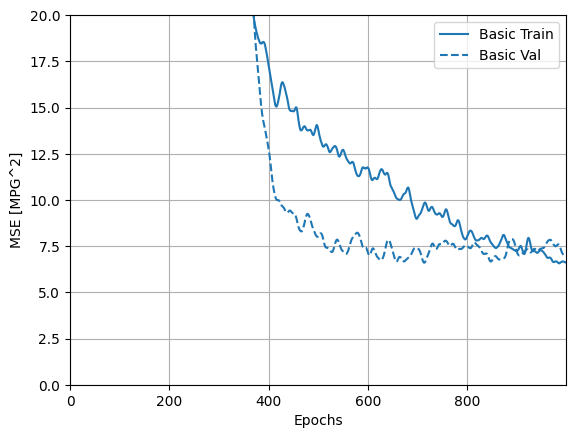

In [32]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

Now determine how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [33]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 7.1356 - mae: 2.0942 - mse: 7.1356 - 92ms/epoch - 31ms/step
Testing set Mean Abs Error:  2.09 MPG


### Make predictions

Finally, predict MPG values using data in the testing set:

3/3 [==============================] - 0s 6ms/step


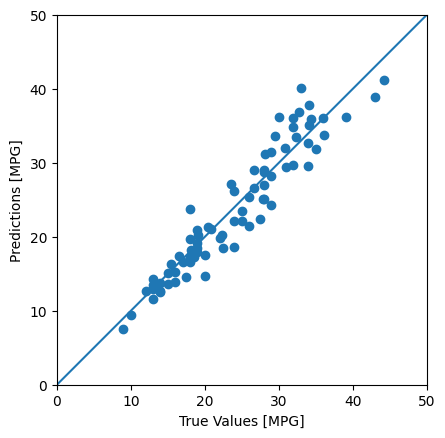

In [34]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
